需要下載Prof. A. Downey所寫的一份`python`腳本[`Cell2D.py`](https://github.com/AllenDowney/ThinkComplexity2/blob/master/code/Cell2D.py)，下載後將其放到和這個notebook同一個資料夾即可。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import correlate2d
from Cell2D import Cell2D, Cell2DViewer
from matplotlib import rc
rc('animation', html='jshtml')

## 擴散

在$x$處找到粒子的機率可由擴散函數
$$
P(x,t)=\frac{1}{\sqrt{4\pi D t}}e^{-x^2/4 D t}
$$
給出，其中$D$是擴散的*特徵長度*.

### 簡單擴散

一個假想的雙源擴散例子。

In [2]:
class Diffusion(Cell2D):
    
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])
    
    def __init__(self, n, r=0.1):
        self.r = r
        self.array = np.zeros((n, n), np.float)
        
    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

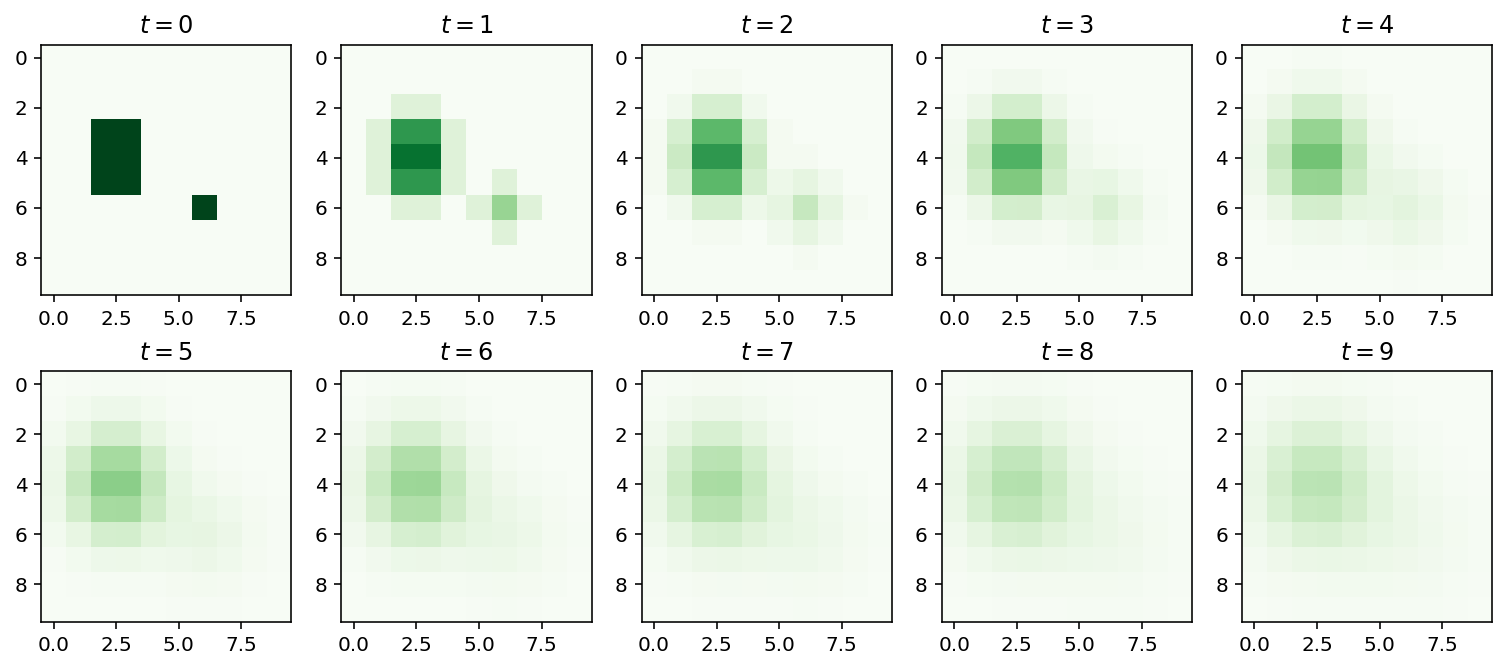

In [3]:
diff = Diffusion(n=10,r=0.15)
diff.add_cells(3, 2, '11', '11', '11')
diff.add_cells(6, 6, '1')

# Drawing the status of the diffusion at any time t
plt.figure(figsize=(13,5.5))

for i in range(10):    
    
    if i==0:
        plt.subplot(2,5,i+1)
        plt.imshow(diff.array,cmap="Greens",vmin=0,vmax=1)
        plt.title("$t=$"+str(i))    

    else:
        diff.step()        
        plt.subplot(2,5,i+1)
        plt.imshow(diff.array,cmap="Greens",vmin=0,vmax=1)
        plt.title("$t=$"+str(i))

## 滲透: 黴菌根系的生長

給定基質並在特定位置種下黴菌的孢子，我們看黴菌的根系在基質上如何滲透。以下會生成方形陣列為培養區域 (plate)，元素1表示黴菌可在此基質上生長，元素0則表示不適合生長。其中培養區域出現可生長基質的機率為$q$。

首先建立侵入函數，侵入函數表示該點四周 (東南西北不含對角線) 方向是否存在黴菌：
$$
\begin{array}{ccc}
\times & {\rm N} & \times\\
{\rm W} & ? & {\rm E}\\
\times & {\rm S} & \times
\end{array}
$$
透過`correlate2d`計算$?$處鄰近NSWE四處的值，每個方向權重接取1。由於在下面若該處有菌點則元素值是5，故只要任一處有菌點則關連矩陣在$?$處的值至少大於等於5，最大是20，所以我們用該處關連矩陣的元素值除以20來決定是否被侵入的機率，並用`np.random.choice`來決定。

In [4]:
# is the given location being penetrated by its neighborhodd
def penetration(nei):
    
    row,col = nei.shape
    pen = np.zeros((row,col))
    
    # given the fraction of the neighborhood population to the maximum neighborhodd tolerance (6 unit in each location and total 4 locations)
    # the fraction is the chance of being penetrated
    for r in range(row):
        for c in range(col):            
            pen[r,c] = np.random.choice([1,0],p=[nei[r,c]/120,1-nei[r,c]/120])
    return pen

In [5]:
# caculating if the total population in a given location is over-populated
# input is the total population in a given location
def overpop(tot):
    
    row,col = tot.shape
    die = np.zeros((row,col))
    
    # given the fraction of the total population to the maximum tolerance (6 unit in each location and total 5 locations)
    # the fraction is the chance of being over-populated
    for r in range(row):
        for c in range(col):
            die[r,c] = np.random.choice([1,0],p=[tot[r,c]/150,1-tot[r,c]/150])
            
    return die

In [6]:
# spores from colonies
def spore(arr):        
    row,col=arr.shape
    
    # randomly add spore on the petri dish 
    arr[np.random.randint(row),np.random.randint(col)] = 5
    return arr

In [7]:
# mold class
class mold():
    
    # calculating neighbor population: excluding center
    nei = np.array([[0, 1, 0],
                    [1, 0, 1],
                    [0, 1, 0]])
    
    # calculating total population: including center
    tot = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]]) 
        
    def __init__(self,n,m):
                
        self.n = n
        
        # generating the petri dish as an (n,n) array
        # array elements are 0 for no mold
        self.array = np.zeros((n,n))
        
        # randomly add mold spots
        # the mold spot is 5 a unit 
        for i in range(m):
            self.array[np.random.randint(n),np.random.randint(n)] = 5
    
    # calculating the evolution of the mold at each step
    def step(self):    
        
        a = self.array
        
        # neighbor population of the mold at given location
        neicorr = correlate2d(a,self.nei,mode='same')
        # total population of the mold at given location
        totcorr = correlate2d(a,self.tot,mode='same')
        
        # does the given location being penetrated by the neighboring mold?
        # 1 for true and 0 for false
        pen = penetration(neicorr)
        # does the given location is over-populated?
        # 1 for true and 0 for false
        over = overpop(totcorr)
        
        # if the given location contains 1 unit of mold and is over-populated,
        # then minus 1 unit of mold
        self.array[(a>=10) & (over==1)] -= 10
        
        # if the given location has at least 1 unit of mold in its neighborhood and is being penetrated,
        # then add 1 unit of mold
        self.array[(neicorr>=5) & (pen==1)] += 5
        
        # at any given location, it can serve no more than 6 units of mold
        # if it is greater than 6*5=30, then truncates it at 30
        self.array[a>=30] = 30
        
        # does it reach the condition for spreading spores?
        
        mold_num = np.sum(self.array)
        if (mold_num) > 5000000 & bool(np.random.choice([1,0],p=[0.1,0.9])):
            self.array = spore(self.array)
        else:
            pass
        
    # get current status of the petri dish
    def status(self):
        return self.array

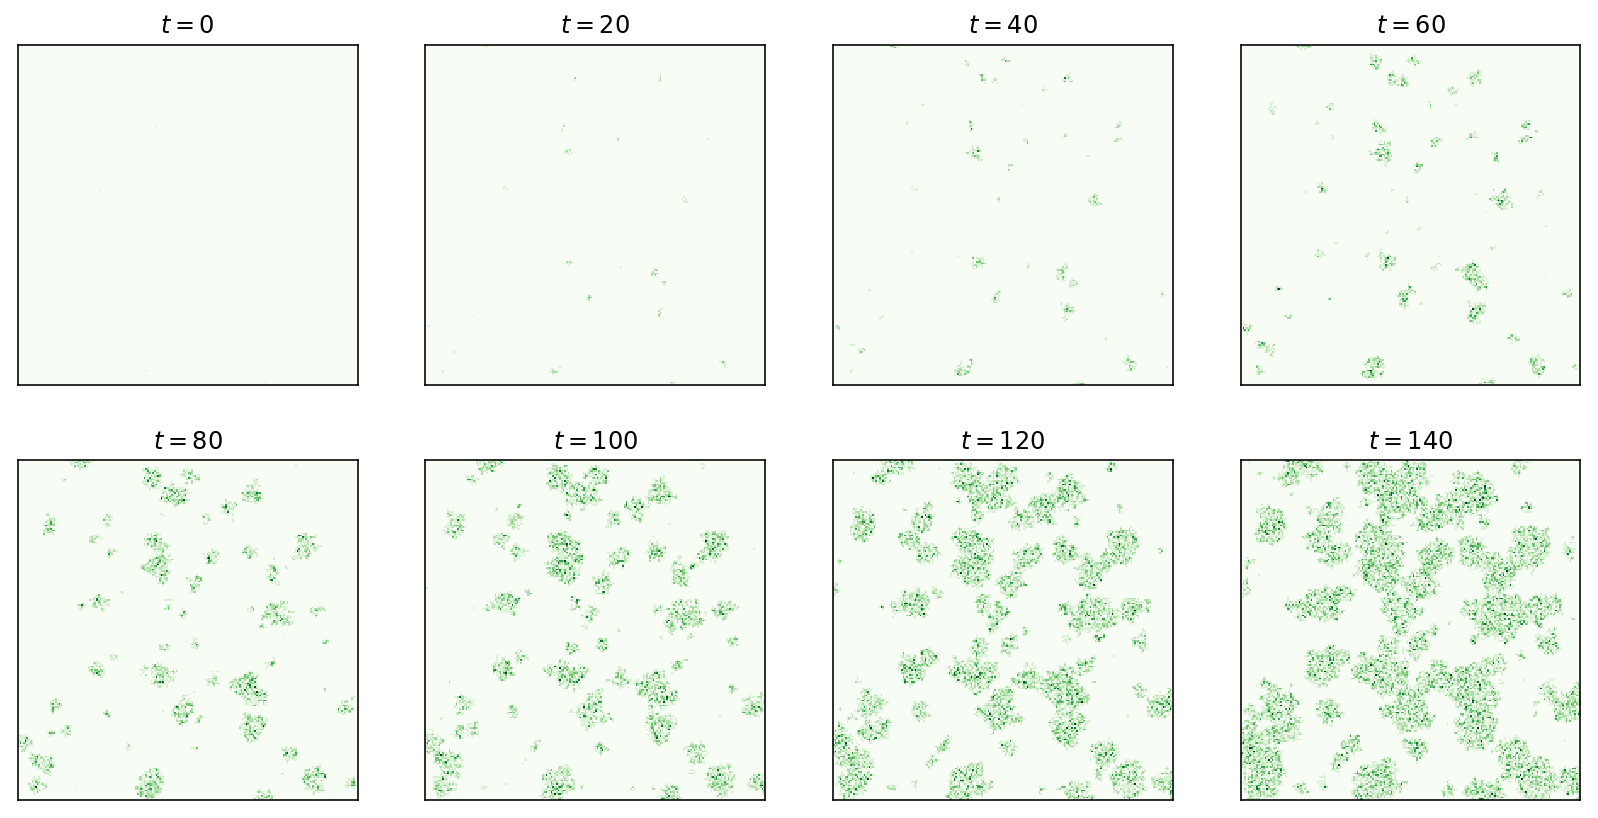

In [8]:
mm=mold(n=200,m=5)

plt.figure(figsize=(14,7))

for i in range(141):
    mm.step()
        
    if i%20==0:
        plt.subplot(2,4,i//20+1)
        plt.imshow(mm.status(),cmap="Greens",vmin=0,vmax=30)
        plt.title("$t=$"+str(i))
        plt.xticks([])
        plt.yticks([])
        
plt.savefig("mold_mm.png",dpi=300,bbox_inches = 'tight')

In [9]:
# 使用Cell2D所提供的Cell2DViewer類來建立動畫
class MoldViewer(Cell2DViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Greens')
    options = dict(alpha=0.6,
                   interpolation='nearest', 
                   vmin=0, vmax=30)

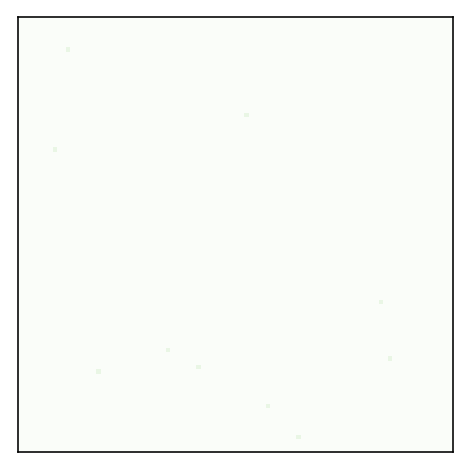

In [10]:
mm = mold(n=100,m=10)
viewer = MoldViewer(mm)
anim = viewer.animate(frames=150)

In [11]:
anim

In [12]:
anim.save('mold_growth.gif',writer="imagemagick",dpi=150)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])